# Prédiction des émissions de gaz à effet de serre

### Préparation de l'environnement et chargement des données

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Models selections

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Métriques 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Standardisation 
from sklearn.preprocessing import StandardScaler

# Modèles linéaires
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

# Modèle de Support Vector Machin
from sklearn.svm import SVR

# Modèles ensemblistes 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

import xgboost as xgb


# Modèle de régression KNN
from sklearn.neighbors import KNeighborsRegressor

# Modèle dummy 
from sklearn.dummy import DummyRegressor

# Modèle deep learning (perceptron multi-couches) 
from sklearn.neural_network import MLPRegressor

# Feature Selection
import shap

#Timer
from timeit import default_timer as timer


In [2]:
def Regressor_comparison(X_train, X_test, y_train, y_test,param_grid,cv=3, n_jobs = -1, randomized_cv = False,random_state_cv = 0, randomized_n_iter = 10) :
    """ Cette fonction permet de tester et comparer en parallèle de nombreux modèles en utilisant la validation croisée. 
    Entrées : les Données d'entrainement (X et y), les données de test (X et y), un dictionnaire de paramètre (détaillé ci-dessous), 
              le nombre de 'fold' pour la validation croisée, le nombre de coeurs alloués (-1 : tous les coeurs).
              L'argument randomized_cv = True permet de lancer RandomizedSearchCV à la place de GridsearchCV. 
              Le random-state et le nombre d'itérations peuvent ensuite etre renseignés.
    Sortie : un dataframe contenant les modèles,les paramètres optimaux ,les top scores (R2) sur les données d'entrainements,
             le temps d'entrainement (lié à l'algorithme et au nombre d'hyperparamètre testé),
             le R2, MSE, RMSE et MAE des données de test. 

    Format du dictionnaire param_grid :

    param_grid ={
    'GradientBoosting_Reg' : 
        {
        'model' : GradientBoostingRegressor(),
        'params' : {
            'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'n_estimators': np.linspace(10, 200, 20,dtype=int)
                    }
        }, 
    'Lasso':{
        'model' : Lasso(),
        'params' : {
           'alpha': np.linspace(0.1, 5, 10),
           'tol' : [0.01],
           'max_iter':[10000]
                    }
        }
    }
    """
    
    scores=[]


    for model_name,mp in param_grid.items():
        if randomized_cv:
            model_compare = RandomizedSearchCV(mp['model'],mp['params'],cv=cv,return_train_score=False,n_jobs=n_jobs,random_state = random_state_cv, n_iter=randomized_n_iter)

        else: 
            model_compare = GridSearchCV(mp['model'],mp['params'],cv=cv,return_train_score=False,n_jobs=n_jobs)

        start = timer()
        model_compare.fit(X_train,y_train)
        end = timer()
        y_pred=model_compare.predict(X_test)
        scores.append({
            'model' : model_name,
            'top_params' : str(model_compare.best_params_),
            'top_score_train' : model_compare.best_score_.round(3),
            'fit_time' : end-start,
            'R2_test' : r2_score(y_test,y_pred).round(3),
            'MSE_test' : mean_squared_error(y_test,y_pred,squared=False).round(3),
            'RMSE_test' : mean_squared_error(y_test,y_pred).round(3),
            'MAE_test' : round(np.mean(abs(y_pred - y_test)), 3)
        })

    output = pd.DataFrame(scores).copy()
    
    return output

In [3]:
# Chargement du dataframe
df=  pd.read_csv("2016_Building_Energy_Benchmarking_model.csv",sep=';')


### Comparaison des différents modèles

In [4]:
#Préparation d'un dictionnaire des paramètres pour la fonction regression_comparison
param_grid ={
    'Dummy_regression':{
        'model' : DummyRegressor(),
        'params' : {
            'strategy' : ['mean']
                    }
    },
    'linear_regression':{
        'model' : LinearRegression(),
        'params' : {
                    }
    },
    'Ridge':{
        'model' : Ridge(random_state=0),
        'params' : {
            'alpha': np.linspace(0.001, 10, 30)
                }
    },
    'Lasso':{
        'model' : Lasso(random_state=0),
        'params' : {
           'alpha': np.linspace(0.001, 10, 30),
           'tol' : [0.01],
           'max_iter':[10000]
                    }
    },
    'ElasticNet':{
        'model' : ElasticNet(random_state=0),
        'params' : {
            'alpha': np.linspace(0.001, 10, 30)
                    }
    },
    'SVR':{
        'model' : SVR(),
        'params' : {
        'C' : np.logspace(-2, 3, 6),
        'gamma' : np.logspace(-2, 1, 4)
                }
    },
    'KNN' : {
        'model' : KNeighborsRegressor(),
        'params' : {
        'n_neighbors':[3, 5, 7, 9, 11, 13, 15]  
            }
    },
    'Bagging_Reg' : {
        'model' : BaggingRegressor(random_state=0),
        'params' : {
        'n_estimators': np.linspace(10, 200, 20,dtype=int)
         },
    },
    'random_forest' : {
        'model' : RandomForestRegressor(random_state=0),
        'params' : {
        'n_estimators': np.linspace(10, 200, 20,dtype=int)
         }
    },
    'AdaBoost_Reg' : {
        'model' : AdaBoostRegressor(random_state=0),
        'params' : {
        'n_estimators': np.linspace(3, 1000, 20,dtype=int)
         }
    },
    'GradientBoosting_Reg' : {
        'model' : GradientBoostingRegressor(random_state=0),
        'params' : {
        'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': np.linspace(10, 400, 30,dtype=int)
         }
    },
    'XGBoost_reg' : {
        'model' : xgb.XGBRegressor(random_state=0),
        'params' : {
        'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': np.linspace(10, 400, 20,dtype=int)
         }
    },
    'Perceptron_reg' : {
        'model' : MLPRegressor(random_state=0),
        'params' : {
            'max_iter':[2000],
           # 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
                    }
    },
}

In [5]:
# Certains algorithmes comme la régression Lasso, Ridge et ElasticNet requiert une standardisation des données (centré sur 0 et d'écart type 1)
# afin d'être pertinent sur la pondération des variables.

# Nous allons tester ici l'effet de la standardisation : 

lst_variables = ['Longitude','Latitude','ENERGYSTARScore',
                 'YearBuilt','Parking_per','Largest_UseType_per','NumberofFloors','NumberofBuildings','PropertyGFATotal']
                 
X = df.drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y = df['TotalGHGEmissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

scaler = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[lst_variables] = scaler.fit_transform(X_train_sc[lst_variables])

X_test_sc = X_test.copy()
X_test_sc[lst_variables] = scaler.transform(X_test_sc[lst_variables])

Scores_Emission_sc = Regressor_comparison(X_train_sc, X_test_sc, y_train, y_test,param_grid,cv=5)
Scores_Emission_sc

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,Dummy_regression,{'strategy': 'mean'},-0.018,7.955082,-0.003,1.339,1.792,1.062
1,linear_regression,{},0.626,0.078977,0.607,0.839,0.703,0.685
2,Ridge,{'alpha': 1.3801724137931035},0.630,0.463469,0.606,0.839,0.704,0.685
3,Lasso,"{'alpha': 0.001, 'max_iter': 10000, 'tol': 0.01}",0.630,0.482568,0.603,0.843,0.710,0.686
4,ElasticNet,{'alpha': 0.001},0.630,0.485457,0.604,0.841,0.707,0.685
5,SVR,"{'C': 10.0, 'gamma': 0.01}",0.616,5.188101,0.597,0.849,0.720,0.666
6,KNN,{'n_neighbors': 5},0.390,0.197509,0.432,1.008,1.015,0.801
7,Bagging_Reg,{'n_estimators': 200},0.577,26.288977,0.598,0.848,0.718,0.676
8,random_forest,{'n_estimators': 200},0.578,24.475392,0.597,0.849,0.721,0.677
9,AdaBoost_Reg,{'n_estimators': 107},0.508,30.398718,0.523,0.923,0.853,0.778


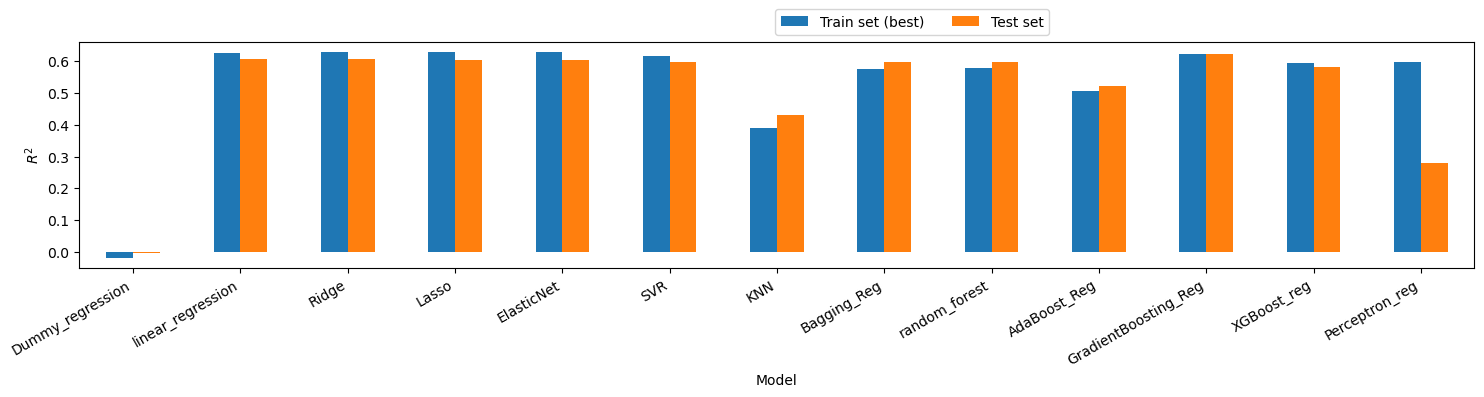

In [6]:
fig = plt.figure(figsize=(18,3),dpi=100)

Scores_Emission_sc[['model','top_score_train','R2_test']].plot(kind="bar", x='model', ax = plt.gca())
plt.legend(loc='lower right', labels=['Train set (best)', 'Test set'],ncol=2,bbox_to_anchor=(0.7, 1.0)
#title='Dataset :',
    )
plt.xlabel(xlabel='Model')
plt.ylabel(ylabel="$R^2$")
plt.xticks(rotation=30, ha='right')
plt.show()

In [7]:
# Changement des conditions de départ (nouveau random state pour le split des données)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 42)

scaler = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[lst_variables] = scaler.fit_transform(X_train_sc[lst_variables])

X_test_sc = X_test.copy()
X_test_sc[lst_variables] = scaler.transform(X_test_sc[lst_variables])

Scores_Emission_sc = Regressor_comparison(X_train_sc, X_test_sc, y_train, y_test,param_grid,cv=5)
Scores_Emission_sc

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,Dummy_regression,{'strategy': 'mean'},-0.014,0.028035,-0.014,1.225,1.501,0.986
1,linear_regression,{},0.633,0.043455,0.604,0.765,0.585,0.598
2,Ridge,{'alpha': 0.3457931034482759},0.633,0.464836,0.605,0.764,0.584,0.598
3,Lasso,"{'alpha': 0.001, 'max_iter': 10000, 'tol': 0.01}",0.633,0.607559,0.609,0.760,0.578,0.598
4,ElasticNet,{'alpha': 0.001},0.632,0.485291,0.607,0.762,0.581,0.598
5,SVR,"{'C': 10.0, 'gamma': 0.01}",0.603,5.225606,0.606,0.764,0.583,0.581
6,KNN,{'n_neighbors': 9},0.414,0.158276,0.379,0.959,0.920,0.775
7,Bagging_Reg,{'n_estimators': 200},0.589,26.233250,0.588,0.780,0.609,0.615
8,random_forest,{'n_estimators': 200},0.589,24.203983,0.587,0.781,0.611,0.616
9,AdaBoost_Reg,{'n_estimators': 265},0.526,49.410878,0.492,0.867,0.752,0.724


### Optimisation du meilleur modèle

In [8]:
param_grid ={
    'GradientBoosting_Reg' : {
        'model' : GradientBoostingRegressor(random_state=42),
        'params' : {
        "max_leaf_nodes": [2, 5, 10, 20, 50],
        'max_depth': [1,2,3,4,5,10, 15,20],
        'subsample' : np.arange(0.1, 1.1, 0.1),
        'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': np.linspace(10, 400, 30,dtype=int)
         }
    }
}

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

scaler = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[lst_variables] = scaler.fit_transform(X_train_sc[lst_variables])

X_test_sc = X_test.copy()
X_test_sc[lst_variables] = scaler.transform(X_test_sc[lst_variables])

Scores_Emission_sc  = Regressor_comparison(X_train_sc, X_test_sc, y_train, y_test,param_grid,cv=10,random_state_cv=0, randomized_cv=True, randomized_n_iter= 200)

Scores_Emission_sc

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,GradientBoosting_Reg,"{'subsample': 0.7000000000000001, 'n_estimator...",0.636,260.012848,0.635,0.807,0.652,0.651


In [10]:
# L'algorithme de Gradient Boosting ne requiert pas une standardisation des données.
# Test de l'algorithme sur les données non standardisées : 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

Scores_Emission  = Regressor_comparison(X_train, X_test, y_train, y_test,param_grid,cv=10,random_state_cv=0, randomized_cv=True, randomized_n_iter= 200)

Scores_Emission

,model,top_params,top_score_train,fit_time,R2_test,MSE_test,RMSE_test,MAE_test
0,GradientBoosting_Reg,"{'subsample': 0.7000000000000001, 'n_estimator...",0.638,255.075056,0.636,0.806,0.65,0.652


In [11]:
# Enregristrement des meilleurs hyper-paramètres :
best_params = eval(Scores_Emission.top_params[0])

In [12]:
# Entraînement du modèle définitif : 

X = df.dropna().drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y = df.dropna()['TotalGHGEmissions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)


GBR = GradientBoostingRegressor(random_state=42, **best_params)
GBR.fit(X_train, y_train)
y_pred=GBR.predict(X_test)


print("$R^2$ (Test Set) :" , r2_score(y_test,y_pred).round(3))
print("MSE (Test Set) :" , mean_squared_error(y_test,y_pred,squared=False).round(3))
print("RMSE (Test Set) :" , mean_squared_error(y_test,y_pred).round(3))
print("MAE (Test Set) :" , round(np.mean(abs(y_pred-y_test)), 3))

$R^2$ (Test Set) : 0.636
MSE (Test Set) : 0.806
RMSE (Test Set) : 0.65
MAE (Test Set) : 0.652


### Analyse de la courbe d'apprentissage

In [13]:
from sklearn.model_selection import learning_curve

# La courbe d'apprentissage (learning curve) permet de tester la précision du modèle sur des échantillons du dataframe de plus en plus grand. 
N, train_score, val_score = learning_curve(GBR, X_train, y_train, train_sizes=np.linspace(0.1,1,10), cv=10)

train_score = pd.DataFrame(train_score, index = N).T.melt()
val_score = pd.DataFrame(val_score, index = N).T.melt()

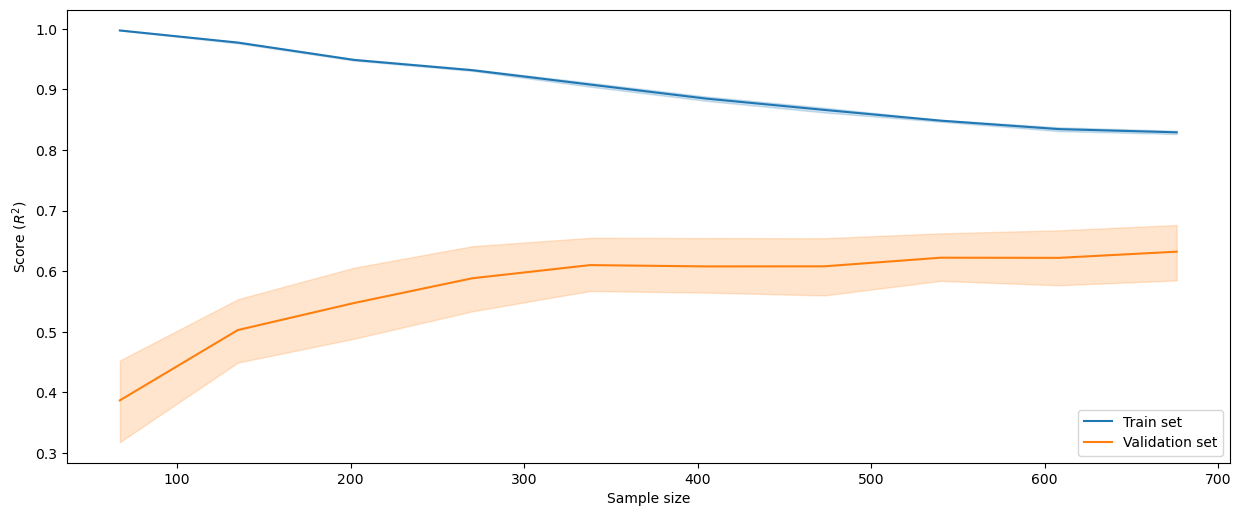

In [14]:

plt.figure(figsize=(15,6),dpi=100)
sns.lineplot(data= train_score, x="variable", y="value", label='Train set')
sns.lineplot(data= val_score, x="variable", y="value",label= 'Validation set')
#plt.xlim([0, 601])
plt.xlabel("Sample size")
plt.ylabel("Score ($R^2$)")
plt.legend(loc = 'lower right')
plt.show()



### Analyse de l'importance des variables

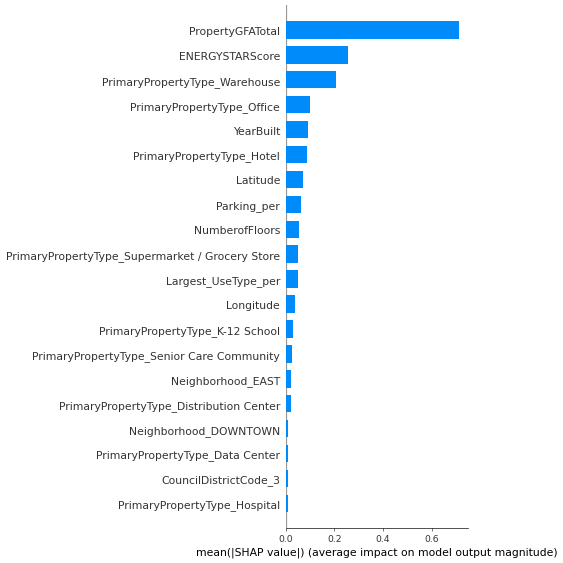

In [15]:
# L'importance des variables sera ici testé par la méthode de Shapley
# Plus la valeur SHAP est importante, plus la variable affecte la valeur prédite. 
shap_values = shap.TreeExplainer(GBR).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(GBR).shap_interaction_values(X_test)
plt.figure(figsize=(10,6),dpi=60)
shap.summary_plot(shap_values, X_test, plot_type="bar")


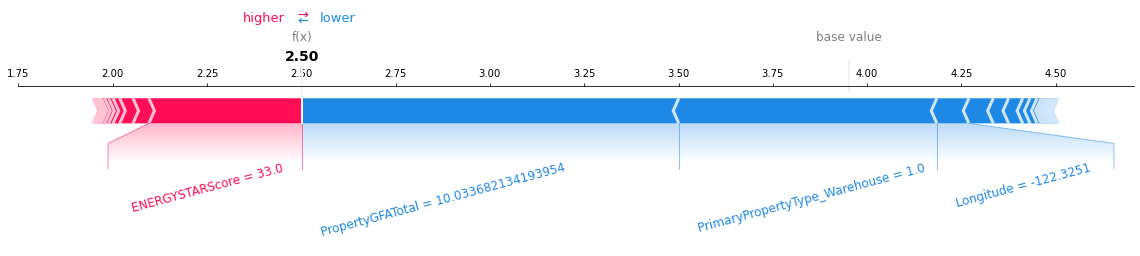

In [16]:
# Représentation de l'effet des variables sur un bâtiment
shap.initjs()
i = 100
shap.force_plot(shap.TreeExplainer(GBR).expected_value, shap_values[i], X_test.iloc[i,:],show=False,matplotlib=True,text_rotation=15).savefig('scratch.png')

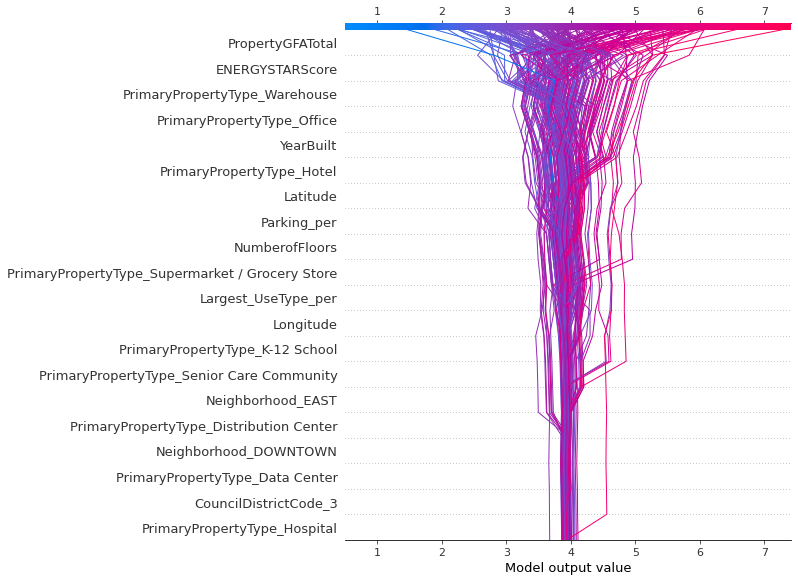

In [17]:
# Représentation de l'effet des variables sur tout le dataframe

shap.decision_plot(shap.TreeExplainer(GBR).expected_value, shap_values, features = X_test.columns)

In [18]:
# Entraînement du modèle sans la variable ENERGYSTARScore

X = df.dropna().drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)','ENERGYSTARScore'])
y = df.dropna()['TotalGHGEmissions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

GBR2 = GradientBoostingRegressor(random_state=42, **best_params)
GBR2.fit(X_train, y_train)
y_pred2=GBR2.predict(X_test)


print("$R^2$ (Test Set) :" , r2_score(y_test,y_pred2).round(3))
print("MSE (Test Set) :" , mean_squared_error(y_test,y_pred2,squared=False).round(3))
print("RMSE (Test Set) :" , mean_squared_error(y_test,y_pred2).round(3))
print("MAE (Test Set) :" , round(np.mean(abs(y_pred2-y_test)), 3))

$R^2$ (Test Set) : 0.594
MSE (Test Set) : 0.852
RMSE (Test Set) : 0.726
MAE (Test Set) : 0.67


### Analyse des valeurs prédites vs valeurs vraies

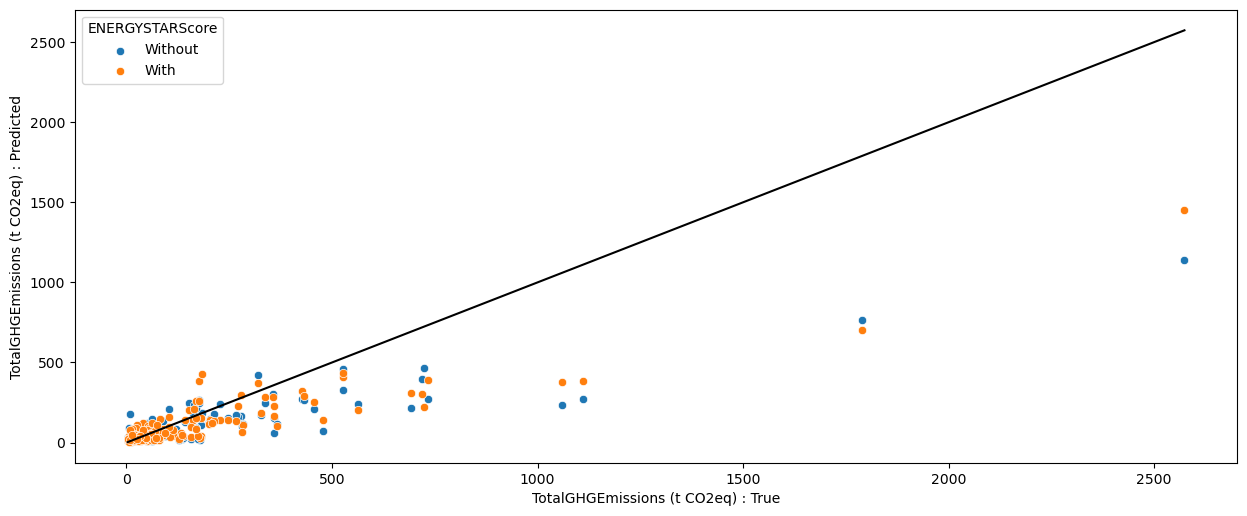

In [19]:
plt.figure(figsize=(15,6),dpi=100)

sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_pred2))
sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_pred))
plt.legend(title='ENERGYSTARScore', loc='upper left', labels=['Without', 'With'])
sns.lineplot(x=np.expm1(y_test), y=np.expm1(y_test),color="black")

plt.xlabel("TotalGHGEmissions (t CO2eq) : True")
plt.ylabel("TotalGHGEmissions (t CO2eq) : Predicted")
plt.show()